In [14]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Dataset loading and processing

In [2]:
# Converting images to tensors and normalize to [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Splitting training into train + validation sets (e.g., 50k train, 10k val)
train_size = int(0.83 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class labels for plotting
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Defining ANN model

In [3]:
# ANN Model Class
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Defining CNN model

In [10]:
# CNN Model Class
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.flattened_size = self._get_flattened_size()

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.pool(x)
            x = torch.flatten(x, 1)
        return x.shape[1]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Training & Evaluation Helper Functions

In [5]:
# ANN model train and evaluation functions
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses


def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    accuracy = 100 * np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test Accuracy: {accuracy:.2f}%")


Training and Testing ANN


🔸 Training ANN Model...
Epoch [1/10], Train Loss: 0.5154, Val Loss: 0.4346, Val Acc: 84.10%
Epoch [2/10], Train Loss: 0.3808, Val Loss: 0.3676, Val Acc: 86.75%
Epoch [3/10], Train Loss: 0.3413, Val Loss: 0.3402, Val Acc: 87.84%
Epoch [4/10], Train Loss: 0.3118, Val Loss: 0.3326, Val Acc: 88.29%
Epoch [5/10], Train Loss: 0.2949, Val Loss: 0.3213, Val Acc: 88.29%
Epoch [6/10], Train Loss: 0.2786, Val Loss: 0.3126, Val Acc: 89.22%
Epoch [7/10], Train Loss: 0.2612, Val Loss: 0.3048, Val Acc: 89.15%
Epoch [8/10], Train Loss: 0.2496, Val Loss: 0.3223, Val Acc: 88.70%
Epoch [9/10], Train Loss: 0.2392, Val Loss: 0.3146, Val Acc: 88.96%
Epoch [10/10], Train Loss: 0.2276, Val Loss: 0.3189, Val Acc: 88.99%


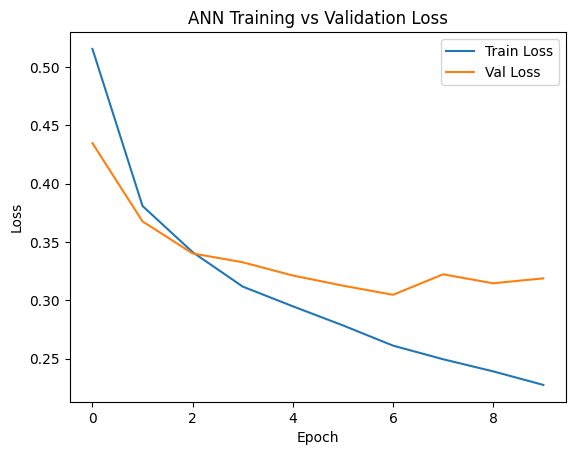


🔸 Evaluating ANN Model...

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.79      0.89      0.84      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.80      0.76      0.78      1000
       Dress       0.88      0.89      0.89      1000
        Coat       0.78      0.83      0.80      1000
      Sandal       0.96      0.95      0.95      1000
       Shirt       0.73      0.65      0.69      1000
     Sneaker       0.93      0.94      0.93      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



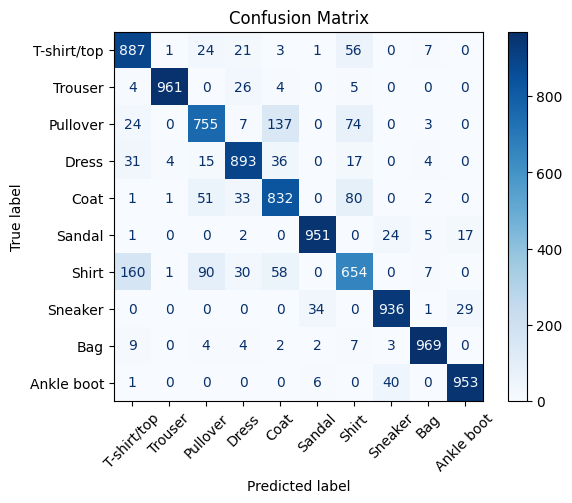

Test Accuracy: 87.91%


In [6]:
# ANN evaluation
ann_model = ANNModel()
print("\n🔸 Training ANN Model...")
train_losses_ann, val_losses_ann = train_model(ann_model, train_loader, val_loader, epochs=10, lr=0.001)

plt.plot(train_losses_ann, label='Train Loss')
plt.plot(val_losses_ann, label='Val Loss')
plt.title("ANN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("\n🔸 Evaluating ANN Model...")
evaluate_model(ann_model, test_loader)


Training and Testing CNN

In [11]:
# CNN Model Training and evaluation function
def train_cnn_model(model, train_loader, val_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses


In [12]:
# cnn model evaluation function
def evaluate_cnn_model(model, test_loader, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45, cmap="Blues")
    plt.title("CNN Confusion Matrix")
    plt.show()

    accuracy = 100 * np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test Accuracy: {accuracy:.2f}%")



🔸 Training CNN Model...
Epoch [1/5] - Train Loss: 0.4442, Val Loss: 0.2758, Val Acc: 89.80%
Epoch [2/5] - Train Loss: 0.2725, Val Loss: 0.2549, Val Acc: 90.26%
Epoch [3/5] - Train Loss: 0.2178, Val Loss: 0.2154, Val Acc: 91.78%
Epoch [4/5] - Train Loss: 0.1747, Val Loss: 0.2024, Val Acc: 92.44%
Epoch [5/5] - Train Loss: 0.1461, Val Loss: 0.2090, Val Acc: 92.82%


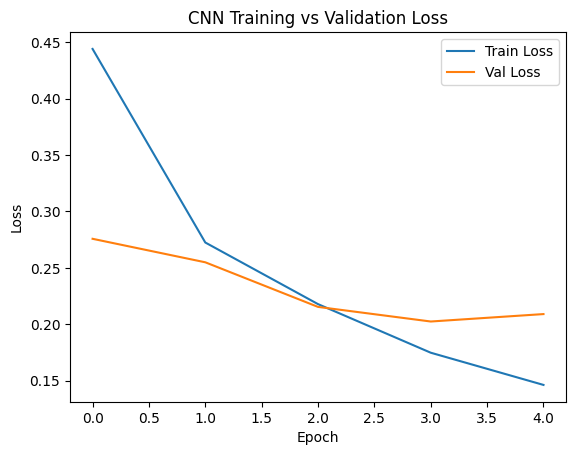


🔸 Evaluating CNN Model...

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.92      0.85      0.88      1000
       Dress       0.90      0.92      0.91      1000
        Coat       0.86      0.90      0.88      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.76      0.80      0.78      1000
     Sneaker       0.98      0.93      0.96      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.94      0.99      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



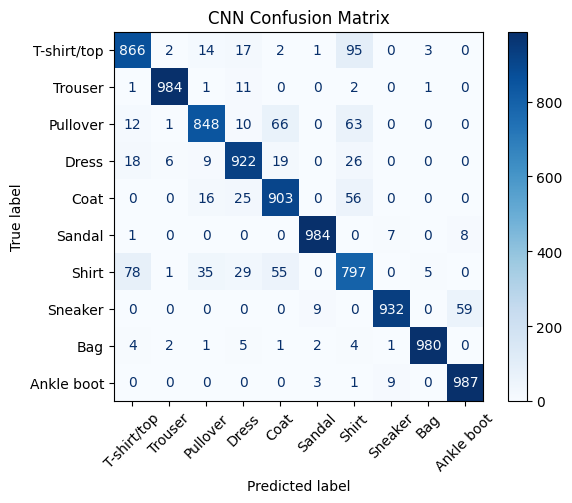

Test Accuracy: 92.03%


In [13]:
# CNN evaluation
cnn_model = CNNModel()
print("\n🔸 Training CNN Model...")
train_losses_cnn, val_losses_cnn = train_cnn_model(cnn_model, train_loader, val_loader, epochs=5, lr=0.001)

plt.plot(train_losses_cnn, label="Train Loss")
plt.plot(val_losses_cnn, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training vs Validation Loss")
plt.legend()
plt.show()

print("\n🔸 Evaluating CNN Model...")
evaluate_cnn_model(cnn_model, test_loader, classes=classes)
